# Рекомендательные системы ДЗ 3

## Файзуллов Айрат

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
dataset_root_dir = 'drive/MyDrive/HW_REC_3'

Mounted at /content/drive


In [2]:
import zipfile
import os

with zipfile.ZipFile('drive/MyDrive/HW_REC_3/archive_rec.zip', 'r') as zip_ref:
    zip_ref.extractall('drive/MyDrive/HW_REC_3')

In [3]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

from pprint import pprint

DATA_PATH = 'drive/MyDrive/HW_REC_3'
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)

catalogue = {int(k): v for k, v in catalogue.items()}

In [4]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

In [5]:
len(list(test_users)[:10000])

10000

In [6]:
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

In [7]:
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

In [8]:
user_counts = ratings['user_uid'].value_counts()
selected_users = user_counts[user_counts > 40].index
ratings = ratings[ratings['user_uid'].isin(selected_users)]

In [9]:
ratings['user_uid'].drop_duplicates()

1          63140
60         43752
118         1120
126       470909
131       183700
           ...  
377730    356071
377875    571326
397432     64806
413112     64947
416795    160242
Name: user_uid, Length: 597, dtype: uint32

In [10]:
max(list(ratings['user_uid'].drop_duplicates()))

592241

Создадим тестовые данные, возьмем каждую пятую пару user и element для каждого user

In [11]:
check_table = ratings

In [12]:
check_table = ratings[ratings['user_uid'] == 63140][::5]

for i in list(ratings['user_uid'].drop_duplicates()):
  tmp_rable = ratings[ratings['user_uid'] == i][::5]
  check_table = pd.concat([check_table, tmp_rable], ignore_index=True)

In [13]:
check_table = check_table[['user_uid', 'element_uid', 'rating']].drop_duplicates()
check_table.shape

(10021, 3)

In [14]:
check_table.head(10)

,user_uid,element_uid,rating
0,63140,3037,10
1,63140,2693,10
2,63140,6140,8
3,63140,2822,10
4,63140,7901,9
5,63140,9700,10
6,63140,1124,10
7,63140,2714,8
8,63140,6099,8
18,43752,8829,8


Созадим данные для train

In [15]:
table_train = ratings.copy()

In [16]:
table_train = table_train[['user_uid', 'element_uid', 'rating']]
merged_df = pd.merge(table_train, check_table, on=['user_uid', 'element_uid', 'rating'], how='left', indicator=True)


# Отбираем только те строки, которые есть только в df1
result_df_train = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
result_df_train.head(3)

,user_uid,element_uid,rating
2,43752,9912,9
3,43752,517,7
4,43752,5139,10


In [17]:
table_train = result_df_train

In [18]:
table_train.shape

(38790, 3)

In [19]:
ratings

,user_uid,element_uid,rating,ts
1,63140,3037,10,4.430514e+07
60,43752,8829,8,4.430408e+07
62,43752,9912,9,4.430406e+07
64,43752,517,7,4.430405e+07
65,43752,5139,10,4.430405e+07
...,...,...,...,...
438750,443637,4299,8,4.173160e+07
438752,443637,3777,10,4.173159e+07
438754,443637,9999,8,4.173158e+07
438781,330622,9745,6,4.173091e+07


Подготовка данных для обучения NN

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
data = check_table[['user_uid', 'element_uid']]
data

,user_uid,element_uid
0,63140,3037
1,63140,2693
2,63140,6140
3,63140,2822
4,63140,7901
...,...,...
10025,160242,9093
10026,160242,8946
10027,160242,2639
10028,160242,9767


In [22]:
import torch
import torch.nn as nn


class RankDataset(Dataset):

  def __init__(self, train=True, image_transform=None, label_transform=None):
    if train:
        data_user = list(table_train['user_uid'])
        data_item = list(table_train['element_uid'])
        labels = list(table_train['rating'])
    else:
        data_user = list(check_table['user_uid'])
        data_item = list(check_table['element_uid'])
        labels = list(check_table['rating'])

    if not image_transform:

      self._data_user = torch.tensor(data_user, dtype=torch.int)
      self._data_item = torch.tensor(data_item, dtype=torch.int)
    else:
      self._data_user = image_transform(data_user.astype(np.int))
      self._data_item = image_transform(data_item.astype(np.int))

    if not label_transform:
      self._labels = torch.tensor(labels)
    else:
      self._labels = label_transform(labels)


  def __len__(self,):
    length = len(self._labels)
    return length

  def __getitem__(self, idx):
    data_user = self._data_user[idx]
    data_item = self._data_item[idx]
    label = self._labels[idx]
    return data_user, data_item, label

In [23]:
dataset = RankDataset(train=True)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=2)

In [24]:
dataset = RankDataset(train=False)
val_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

Создадим нейронную сеть с 3 слоями и обучим её

In [25]:
torch.backends.cudnn.benchmark = False
CUDA_LAUNCH_BLOCKING=1

In [26]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, n_u, n_e, dim_e, in_gmf):
        super().__init__()
        self.embed_user = nn.Embedding(n_u, dim_e)
        self.embed_item = nn.Embedding(n_e, dim_e)

        self.embed_user_gmf = nn.Embedding(n_u, dim_e)
        self.embed_item_gmf = nn.Embedding(n_e, dim_e)
        self.layer_gmf = nn.Linear(in_gmf, 1)

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.res_layer = nn.Linear(hidden_size2, 32)
        self.softmax = nn.Softmax(dim=1)

        self.output_layer = nn.Linear(232, output_size)

    def forward(self, u, i):
        user_embeddings = self.embed_user(u.long())
        item_embeddings = self.embed_item(i.long())

        user_embeddings_gmf = self.embed_user_gmf(u.long())
        item_embeddings_gmf = self.embed_item_gmf(i.long())

        gmf_data = user_embeddings_gmf * item_embeddings_gmf

        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.res_layer(x)

        # gmf_data = self.layer_gmf(gmf_data)
        y = torch.cat([gmf_data, x], dim=1)
        y = self.output_layer(y)
        return y

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_loss = torch.nn.MSELoss()
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))

model = SimpleNN(400, 128, 64, 1, max_user + 1, max_item + 1, 200, 200)


print(device)
arr_loss = []
arr_loss_val = []

model.to(device)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(4):
  model.train()
  cnt = 0
  total_loss = 0
  for users, items, ratings_i in dataloader:

    user = torch.tensor(users).to(device)
    items = torch.tensor(items).to(device)
    ratings_i = ratings_i.to(device)

    model_labels = model(user, items)
    #print(model_labels)
    #print(torch.argmax(model_labels, dim=1))
    new_loss = torch_loss(model_labels, ratings_i.float())
    optimizer.zero_grad()
    cnt += 1
    total_loss += new_loss
    if cnt % 30 == 0:
      print(total_loss/30)
      arr_loss.append(total_loss/30)
      total_loss = 0
      cnt = 0
    #print(new_loss)
    #new_loss = new_loss.float()
    new_loss.backward()
    #print(new_loss)
    optimizer.step()

  model.eval()
  print("____________________EVAL_____________________")
  with torch.no_grad():
    cnt = 0
    total_loss = 0
    for users, items, ratings_i in val_dataloader:
      user = torch.tensor(users).to(device)
      items = torch.tensor(items).to(device)
      ratings_i = ratings_i.to(device)

      model_labels = model(user, items)
      print(model_labels)
      new_loss = torch_loss(model_labels, ratings_i)
      cnt += 1
      total_loss += new_loss
      if cnt % 6:
        arr_loss_val.append(total_loss/6)
        print(total_loss/6)
        total_loss = 0
        cnt = 0

In [28]:
import matplotlib.pyplot as plt

In [77]:
arr_loss_val = [tens.cpu().detach().numpy() for tens in arr_loss_val]

arr_loss = [tens.cpu().detach().numpy() for tens in arr_loss]

In [55]:
chunks_val = np.array_split(arr_loss_val, 4)
chunks_val = [np.mean(i) for i in chunks_val]

chunks = np.array_split(arr_loss, 4)
chunks = [np.mean(i) for i in chunks]

Выводу по обучению

Сделаем выводы по качестве на тестовой выборке. Выведу как менялся RMSE loss в зависиомсти от эпохи и выведу его график.

In [54]:
for i in range(4):
  print('RMSE loss on epoch number ', i+1)
  print(chunks_val[i])

RMSE loss on epoch number  1
0.591721
RMSE loss on epoch number  2
0.56747925
RMSE loss on epoch number  3
0.5673363
RMSE loss on epoch number  4
0.56267214


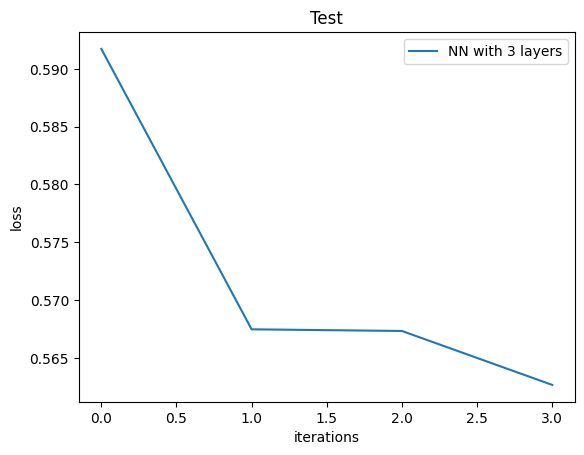

In [56]:
x1 = np.arange(len(chunks_val))

plt.plot(x1, chunks_val, label = "NN with 3 layers")


plt.title('Test')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

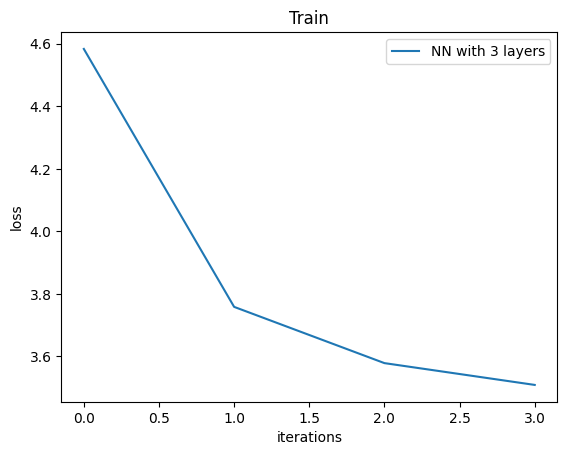

In [57]:
x1 = np.arange(len(chunks))

plt.plot(x1, chunks, label = "NN with 3 layers")


plt.title('Train')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

По графикам можно увидеть, что качество нейронной сети улучшается, но качество растет очень медленно, на валидации меняется только значение после 4го знака после запятой.

Поэтому можно прийти к выводу, что такие нейрости не всегда имеет смысл особо долго обучать, т.к. прирост качества очень мал.

Создадим нейронную сеть с 5 слоями и обучим её

In [27]:
import torch
import torch.nn as nn

class SimpleNN_5layers(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, n_u, n_e, dim_e, in_gmf):
        super().__init__()
        self.embed_user = nn.Embedding(n_u, dim_e)
        self.embed_item = nn.Embedding(n_e, dim_e)

        self.embed_user_gmf = nn.Embedding(n_u, dim_e)
        self.embed_item_gmf = nn.Embedding(n_e, dim_e)
        self.layer_gmf = nn.Linear(in_gmf, 1)

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, 32)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(32, 32)
        self.relu4 = nn.ReLU()
        self.res_layer = nn.Linear(32, 16)
        self.softmax = nn.Softmax(dim=1)

        self.output_layer = nn.Linear(216, output_size)

    def forward(self, u, i):
        user_embeddings = self.embed_user(u.long())
        item_embeddings = self.embed_item(i.long())

        user_embeddings_gmf = self.embed_user_gmf(u.long())
        item_embeddings_gmf = self.embed_item_gmf(i.long())

        gmf_data = user_embeddings_gmf * item_embeddings_gmf

        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu4(x)
        x = self.res_layer(x)

        # gmf_data = self.layer_gmf(gmf_data)
        y = torch.cat([gmf_data, x], dim=1)
        y = self.output_layer(y)
        return y

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_loss = torch.nn.MSELoss()
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))

model = SimpleNN_5layers(400, 128, 64, 1, max_user + 1, max_item + 1, 200, 200)


print(device)
arr_loss5 = []
arr_loss_val5 = []

model.to(device)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(4):
  model.train()
  cnt = 0
  total_loss = 0
  for users, items, ratings_i in dataloader:

    user = torch.tensor(users).to(device)
    items = torch.tensor(items).to(device)
    ratings_i = ratings_i.to(device)

    model_labels = model(user, items)
    #print(torch.argmax(model_labels, dim=1))
    new_loss = torch_loss(model_labels, ratings_i.float())
    optimizer.zero_grad()
    new_loss.backward()
    cnt += 1
    total_loss += new_loss
    if cnt % 30 == 0:
      print(total_loss/30)
      arr_loss5.append(total_loss/30)
      total_loss = 0
      cnt = 0
    optimizer.step()

  model.eval()
  print("____________________EVAL_____________________")
  with torch.no_grad():
    cnt = 0
    total_loss = 0
    for users, items, ratings_i in val_dataloader:
      user = torch.tensor(users).to(device)
      items = torch.tensor(items).to(device)
      ratings_i = ratings_i.to(device)

      model_labels = model(user, items)
      print(model_labels)
      new_loss = torch_loss(model_labels, ratings_i)
      cnt += 1
      total_loss += new_loss
      if cnt % 6:
        arr_loss_val5.append(total_loss/6)
        print(total_loss/6)
        total_loss = 0
        cnt = 0

Выводу по обучению

Сделаем выводы по качестве на тестовой выборке. Выведу как менялся RMSE loss в зависиомсти от эпохи и выведу его график.

In [60]:
arr_loss_val5 = [tens.cpu().detach().numpy() for tens in arr_loss_val5]

arr_loss5 = [tens.cpu().detach().numpy() for tens in arr_loss5]

In [61]:
chunks_val5 = np.array_split(arr_loss_val5, 4)
chunks_val5 = [np.mean(i) for i in chunks_val5]

chunks5 = np.array_split(arr_loss5, 4)
chunks5 = [np.mean(i) for i in chunks5]

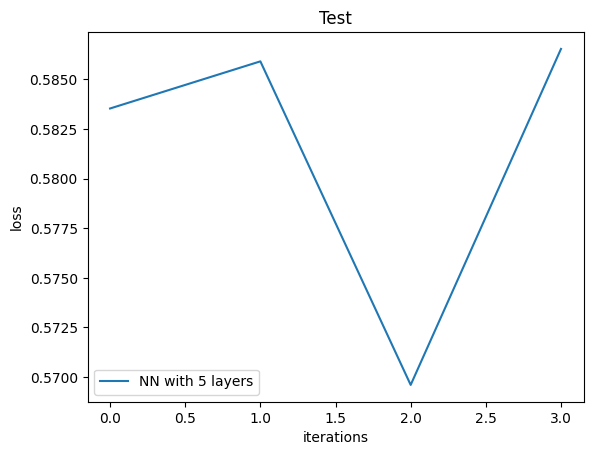

In [69]:
x1 = np.arange(len(chunks_val5))

plt.plot(x1, chunks_val5, label = "NN with 5 layers")


plt.title('Test')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

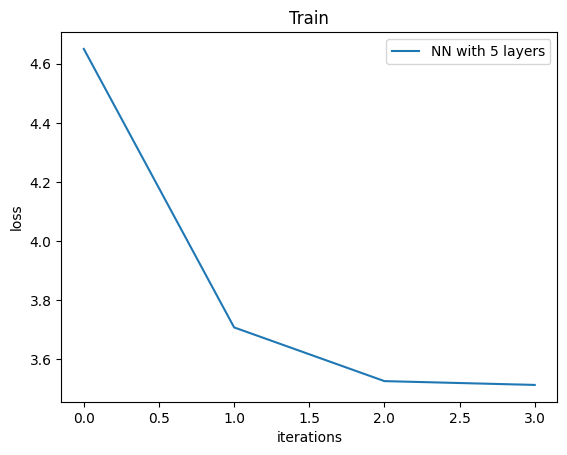

In [72]:
x1 = np.arange(len(chunks5))

plt.plot(x1, chunks5, label = "NN with 5 layers")


plt.title('Train')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

Видим, что модель также обучается, только на валидации она ведёт себя более нестабильно чем модель с 3 слоями. Также можно заметить, что модель с 5 слоями даёт качество хуже (на валидации) чем моедль с 3 слоями. Возможно это вызвано тем, что модель 2 более сложная и ей нужно бОльшее кол-во эпох, чтобы перегнать по качеству моедль 1.

Изобразим на графике сравнение этих 2ух моделей.

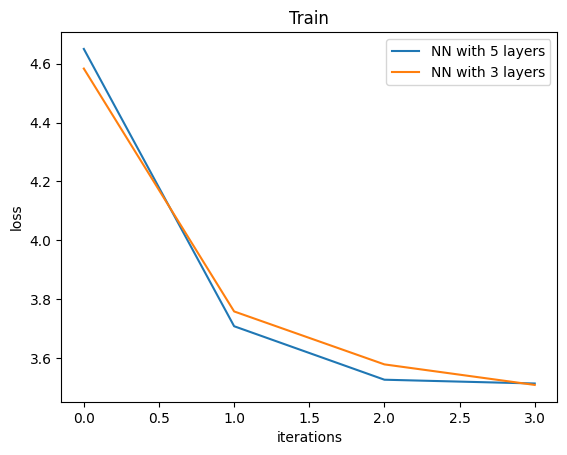

In [74]:
x1 = np.arange(len(chunks5))

plt.plot(x1, chunks5, label = "NN with 5 layers")
plt.plot(x1, chunks, label = "NN with 3 layers")

plt.title('Train')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

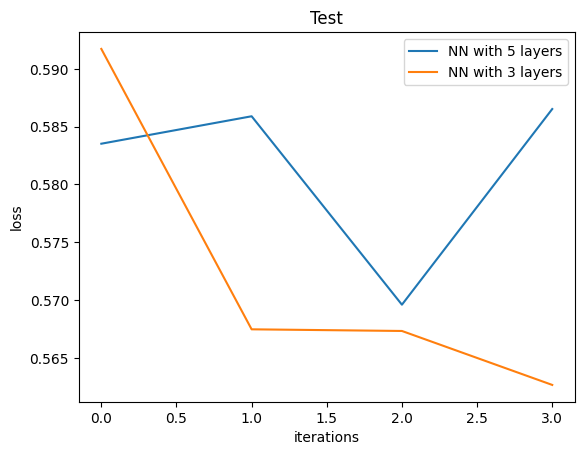

In [75]:
x1 = np.arange(len(chunks_val5))

plt.plot(x1, chunks_val5, label = "NN with 5 layers")
plt.plot(x1, chunks_val, label = "NN with 3 layers")

plt.title('Test')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

Продолжим обучении ещё на 4 эпохи и сравним результаты

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_loss = torch.nn.MSELoss()
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))

model3 = SimpleNN(400, 128, 64, 1, max_user + 1, max_item + 1, 200, 200)


print(device)
arr_loss = []
arr_loss_val = []

model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

for epoch in range(8):
  model3.train()
  cnt = 0
  total_loss = 0
  for users, items, ratings_i in dataloader:

    user = torch.tensor(users).to(device)
    items = torch.tensor(items).to(device)
    ratings_i = ratings_i.to(device)

    model_labels = model3(user, items)
    #print(model_labels)
    #print(torch.argmax(model_labels, dim=1))
    new_loss = torch_loss(model_labels, ratings_i.float())
    optimizer.zero_grad()
    cnt += 1
    total_loss += new_loss
    if cnt % 30 == 0:
      print(total_loss/30)
      arr_loss.append(total_loss/30)
      total_loss = 0
      cnt = 0
    #print(new_loss)
    #new_loss = new_loss.float()
    new_loss.backward()
    #print(new_loss)
    optimizer.step()

  model3.eval()
  print("____________________EVAL_____________________")
  with torch.no_grad():
    cnt = 0
    total_loss = 0
    for users, items, ratings_i in val_dataloader:
      user = torch.tensor(users).to(device)
      items = torch.tensor(items).to(device)
      ratings_i = ratings_i.to(device)

      model_labels = model3(user, items)
      print(model_labels)
      new_loss = torch_loss(model_labels, ratings_i)
      cnt += 1
      total_loss += new_loss
      if cnt % 6:
        arr_loss_val.append(total_loss/6)
        print(total_loss/6)
        total_loss = 0
        cnt = 0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_loss = torch.nn.MSELoss()
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))

model = SimpleNN_5layers(400, 128, 64, 1, max_user + 1, max_item + 1, 200, 200)


print(device)
arr_loss5 = []
arr_loss_val5 = []

model.to(device)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(8):
  model.train()
  cnt = 0
  total_loss = 0
  for users, items, ratings_i in dataloader:

    user = torch.tensor(users).to(device)
    items = torch.tensor(items).to(device)
    ratings_i = ratings_i.to(device)

    model_labels = model(user, items)
    #print(torch.argmax(model_labels, dim=1))
    new_loss = torch_loss(model_labels, ratings_i.float())
    optimizer.zero_grad()
    new_loss.backward()
    cnt += 1
    total_loss += new_loss
    if cnt % 30 == 0:
      print(total_loss/30)
      arr_loss5.append(total_loss/30)
      total_loss = 0
      cnt = 0
    optimizer.step()

  model.eval()
  print("____________________EVAL_____________________")
  with torch.no_grad():
    cnt = 0
    total_loss = 0
    for users, items, ratings_i in val_dataloader:
      user = torch.tensor(users).to(device)
      items = torch.tensor(items).to(device)
      ratings_i = ratings_i.to(device)

      model_labels = model(user, items)
      print(model_labels)
      new_loss = torch_loss(model_labels, ratings_i)
      cnt += 1
      total_loss += new_loss
      if cnt % 6:
        arr_loss_val5.append(total_loss/6)
        print(total_loss/6)
        total_loss = 0
        cnt = 0

In [109]:
arr_loss_val5 = [tens.cpu().detach().numpy() for tens in arr_loss_val5]

arr_loss5 = [tens.cpu().detach().numpy() for tens in arr_loss5]

In [110]:
chunks_val5 = np.array_split(arr_loss_val5, 8)
chunks_val5 = [np.mean(i) for i in chunks_val5]

chunks5 = np.array_split(arr_loss5, 8)
chunks5 = [np.mean(i) for i in chunks5]

In [ ]:
arr_loss_val = [tens.cpu().detach().numpy() for tens in arr_loss_val]

arr_loss = [tens.cpu().detach().numpy() for tens in arr_loss]

In [103]:
chunks_val = np.array_split(arr_loss_val, 8)
chunks_val = [np.mean(i) for i in chunks_val]

chunks = np.array_split(arr_loss, 8)
chunks = [np.mean(i) for i in chunks]

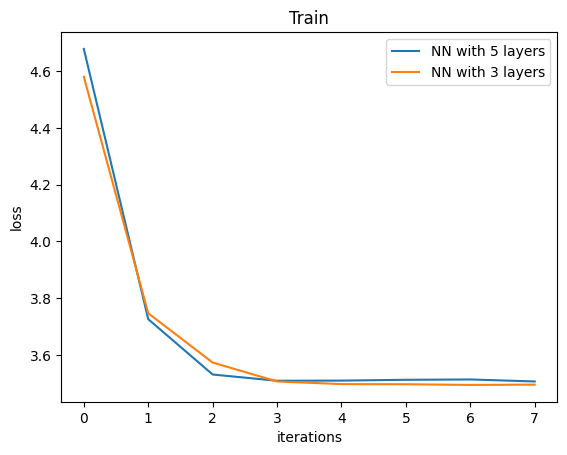

In [111]:
x1 = np.arange(len(chunks5))

plt.plot(x1, chunks5, label = "NN with 5 layers")
plt.plot(x1, chunks, label = "NN with 3 layers")

plt.title('Train')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

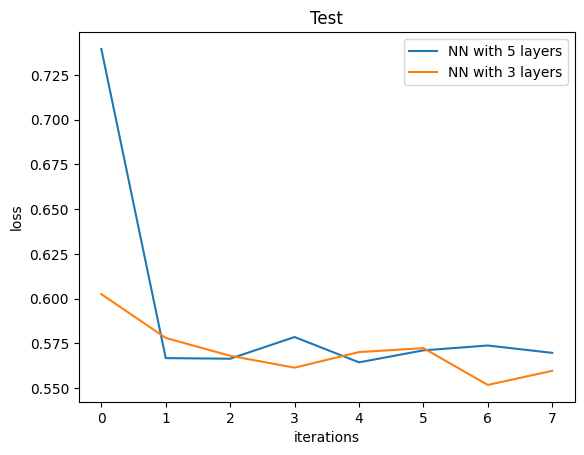

In [113]:
x1 = np.arange(len(chunks_val5))

plt.plot(x1, chunks_val5, label = "NN with 5 layers")
plt.plot(x1, chunks_val, label = "NN with 3 layers")

plt.title('Test')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

Можно заметить, что нет сильного преобладания по качеству у какой либо из моделей. Вероятнее всего модель 5 оказывается неоправданно сложной для этой задачи.

Отсюда можно сделать вывод, что лучше использовать нероннуб сеть с 3 полносвязыными слоями, т.к. эта модель проще и даёт качество сопоставимое с качеством моедли с 5 полносвязнымии слоями.

## Как можно улушить архитектуру?

Все эксперименты буду проводить на модели с 3 полносвязными слоями.

Уменьшу выход с послносвязной сети и уменьшу размер эмбединга.

In [ ]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, n_u, n_e, dim_e, in_gmf):
        super().__init__()
        self.embed_user = nn.Embedding(n_u, dim_e)
        self.embed_item = nn.Embedding(n_e, dim_e)

        self.embed_user_gmf = nn.Embedding(n_u, dim_e)
        self.embed_item_gmf = nn.Embedding(n_e, dim_e)
        self.layer_gmf = nn.Linear(in_gmf, 1)

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.res_layer = nn.Linear(hidden_size2, 12)
        self.softmax = nn.Softmax(dim=1)

        self.output_layer = nn.Linear(22, output_size)

    def forward(self, u, i):
        user_embeddings = self.embed_user(u.long())
        item_embeddings = self.embed_item(i.long())

        user_embeddings_gmf = self.embed_user_gmf(u.long())
        item_embeddings_gmf = self.embed_item_gmf(i.long())

        gmf_data = user_embeddings_gmf * item_embeddings_gmf

        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.res_layer(x)

        #gmf_data = self.layer_gmf(gmf_data)
        y = torch.cat([gmf_data, x], dim=1)
        y = self.output_layer(y)
        return y


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_loss = torch.nn.MSELoss()
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))

model3 = SimpleNN(20, 128, 64, 1, max_user + 1, max_item + 1, 10, 10)


print(device)
arr_loss = []
arr_loss_val = []

model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

for epoch in range(4):
  model3.train()
  cnt = 0
  total_loss = 0
  for users, items, ratings_i in dataloader:

    user = torch.tensor(users).to(device)
    items = torch.tensor(items).to(device)
    ratings_i = ratings_i.to(device)
    model_labels = model3(user, items)
    #print(model_labels)
    #print(torch.argmax(model_labels, dim=1))
    new_loss = torch_loss(model_labels, ratings_i.float())
    optimizer.zero_grad()
    cnt += 1
    total_loss += new_loss
    if cnt % 30 == 0:
      print(total_loss/30)
      arr_loss.append(total_loss/30)
      total_loss = 0
      cnt = 0
    #print(new_loss)
    #new_loss = new_loss.float()
    new_loss.backward()
    #print(new_loss)
    optimizer.step()

  model3.eval()
  print("____________________EVAL_____________________")
  with torch.no_grad():
    cnt = 0
    total_loss = 0
    for users, items, ratings_i in val_dataloader:
      user = torch.tensor(users).to(device)
      items = torch.tensor(items).to(device)
      ratings_i = ratings_i.to(device)

      model_labels = model3(user, items)
      print(model_labels)
      new_loss = torch_loss(model_labels, ratings_i)
      cnt += 1
      total_loss += new_loss
      if cnt % 6:
        arr_loss_val.append(total_loss/6)
        print(total_loss/6)
        total_loss = 0
        cnt = 0

In [37]:
arr_loss_val = [tens.cpu().detach().numpy() for tens in arr_loss_val]

arr_loss = [tens.cpu().detach().numpy() for tens in arr_loss]

In [25]:
import matplotlib.pyplot as plt

In [38]:
chunks_val = np.array_split(arr_loss_val, 8)
chunks_val = [np.mean(i) for i in chunks_val]

chunks = np.array_split(arr_loss, 8)
chunks = [np.mean(i) for i in chunks]

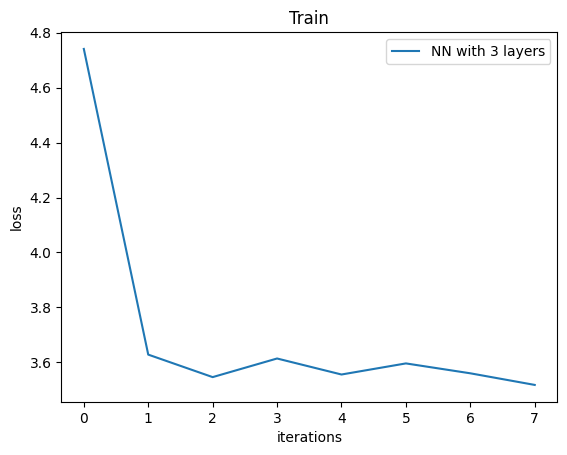

In [39]:
x1 = np.arange(len(chunks))

plt.plot(x1, chunks, label = "NN with 3 layers")

plt.title('Train')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

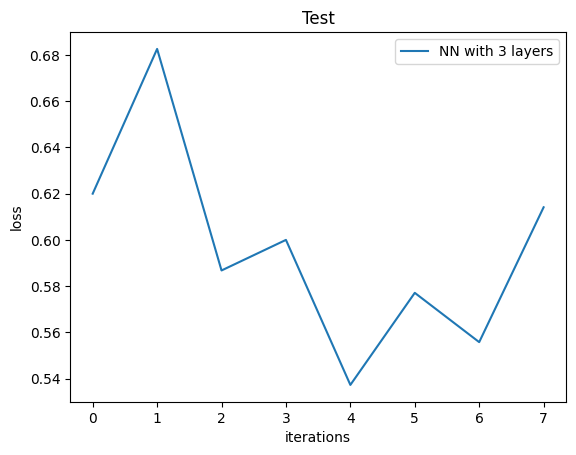

In [40]:
x1 = np.arange(len(chunks_val))

plt.plot(x1, chunks_val, label = "NN with 3 layers")


plt.title('Test')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

Заметного улучшения качества нет, но после 5 эпохи оно дал наилучшее качество среди всех моделей. Однако на валидации она ведёт себя довольно нестабильно, что является минусом.

Можно решать задачу с помощью ансамблирования. Получится модель, которая делает выводы на основе модели с 5 полносвзяными слоями и с 3 полносвзяными слоями. Предсказания сделанные моделью с 5 слоями буду учитывать с весом 0.4, а модель с 3 слоями буду учитывать с весом 0.6

In [45]:
CUDA_LAUNCH_BLOCKING=1

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))
model_3lay = SimpleNN(400, 128, 64, 1, max_user + 1, max_item + 1, 200, 200)

model_3lay.to(device)

model_5lay = SimpleNN_5layers(400, 128, 64, 1, max_user + 1, max_item + 1, 200, 200)

model_5lay.to(device)

SimpleNN_5layers(
  (embed_user): Embedding(592242, 200)
  (embed_item): Embedding(10200, 200)
  (embed_user_gmf): Embedding(592242, 200)
  (embed_item_gmf): Embedding(10200, 200)
  (layer_gmf): Linear(in_features=200, out_features=1, bias=True)
  (layer1): Linear(in_features=400, out_features=128, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (relu4): ReLU()
  (res_layer): Linear(in_features=32, out_features=16, bias=True)
  (softmax): Softmax(dim=1)
  (output_layer): Linear(in_features=216, out_features=1, bias=True)
)

In [30]:
import gdown

In [31]:
output = 'checkpoint5.pth'
gdown.download(f'https://drive.google.com/uc?id=1XOP-pjH9vHkO9uTxF7uFCn3xQ8_GKsoo', output, quiet=False)
output = 'checkpoint.pth'
gdown.download(f'https://drive.google.com/uc?id=1Az4B34qj_1l0FhfLmb5lNo8EfN2ZlcUJ', output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1XOP-pjH9vHkO9uTxF7uFCn3xQ8_GKsoo
To: /content/checkpoint5.pth
100%|██████████| 964M/964M [00:03<00:00, 260MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Az4B34qj_1l0FhfLmb5lNo8EfN2ZlcUJ
To: /content/checkpoint.pth
100%|██████████| 964M/964M [00:07<00:00, 129MB/s]


'checkpoint.pth'

In [32]:
with open('./checkpoint.pth', "rb") as fp:
  state_dict = torch.load(fp)
model_3lay.load_state_dict(state_dict)

with open('./checkpoint5.pth', "rb") as fp:
  state_dict = torch.load(fp)
model_5lay.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
cnt = 0
total_loss = 0
arr_loss_val = []

torch_loss = torch.nn.MSELoss()

for users, items, ratings_i in val_dataloader:
  user = torch.tensor(users).to(device)
  items = torch.tensor(items).to(device)
  ratings_i = ratings_i.to(device)

  model_labels = model_3lay(user, items) * 0.6 + model_5lay(user, items)*0.4
  print(model_labels)
  new_loss = torch_loss(model_labels, ratings_i.float())
  cnt += 1
  total_loss += new_loss
  if cnt % 6:
    arr_loss_val.append(total_loss/6)
    print(total_loss/6)
    total_loss = 0
    cnt = 0

In [37]:
arr_loss_val = [tens.cpu().detach().numpy() for tens in arr_loss_val]

In [39]:
print("Loss на последней эпохе")
np.mean(arr_loss_val)

Loss на последней эпохе


0.56109434

Видим, что значение лосса не улучшается.

Поробуем добавить 2 полносвязных слоя после GMF

In [ ]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, n_u, n_e, dim_e, in_gmf):
        super().__init__()
        self.embed_user = nn.Embedding(n_u, dim_e)
        self.embed_item = nn.Embedding(n_e, dim_e)

        self.embed_user_gmf = nn.Embedding(n_u, dim_e)
        self.embed_item_gmf = nn.Embedding(n_e, dim_e)

        self.layer_gmf = nn.Linear(in_gmf, 32)
        self.relu_gmf = nn.ReLU()
        self.layer_gmf2 = nn.Linear(32, 1)

        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.res_layer = nn.Linear(hidden_size2, 2)
        self.softmax = nn.Softmax(dim=1)

        self.output_layer = nn.Linear(3, output_size)

    def forward(self, u, i):
        user_embeddings = self.embed_user(u.long())
        item_embeddings = self.embed_item(i.long())

        user_embeddings_gmf = self.embed_user_gmf(u.long())
        item_embeddings_gmf = self.embed_item_gmf(i.long())

        gmf_data = user_embeddings_gmf * item_embeddings_gmf

        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.res_layer(x)

        gmf_data = self.layer_gmf(gmf_data)
        gmf_data = self.relu_gmf(gmf_data)
        gmf_data = self.layer_gmf2(gmf_data)

        y = torch.cat([gmf_data, x], dim=1)
        y = self.output_layer(y)
        return y


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_loss = torch.nn.MSELoss()
max_user = max(list(ratings['user_uid'].drop_duplicates()))
max_item = max(list(ratings['element_uid'].drop_duplicates()))

model3 = SimpleNN(200, 128, 64, 1, max_user + 1, max_item + 1, 100, 100)


print(device)
arr_loss = []
arr_loss_val = []

model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

for epoch in range(4):
  model3.train()
  cnt = 0
  total_loss = 0
  for users, items, ratings_i in dataloader:

    user = torch.tensor(users).to(device)
    items = torch.tensor(items).to(device)
    ratings_i = ratings_i.to(device)
    model_labels = model3(user, items)
    #print(model_labels)
    #print(torch.argmax(model_labels, dim=1))
    new_loss = torch_loss(model_labels, ratings_i.float())
    optimizer.zero_grad()
    cnt += 1
    total_loss += new_loss
    if cnt % 30 == 0:
      print(total_loss/30)
      arr_loss.append(total_loss/30)
      total_loss = 0
      cnt = 0
    #print(new_loss)
    #new_loss = new_loss.float()
    new_loss.backward()
    #print(new_loss)
    optimizer.step()

  model3.eval()
  print("____________________EVAL_____________________")
  with torch.no_grad():
    cnt = 0
    total_loss = 0
    for users, items, ratings_i in val_dataloader:
      user = torch.tensor(users).to(device)
      items = torch.tensor(items).to(device)
      ratings_i = ratings_i.to(device)

      model_labels = model3(user, items)
      print(model_labels)
      new_loss = torch_loss(model_labels, ratings_i)
      cnt += 1
      total_loss += new_loss
      if cnt % 6:
        arr_loss_val.append(total_loss/6)
        print(total_loss/6)
        total_loss = 0
        cnt = 0

In [41]:
arr_loss_val = [tens.cpu().detach().numpy() for tens in arr_loss_val]

arr_loss = [tens.cpu().detach().numpy() for tens in arr_loss]

chunks_val = np.array_split(arr_loss_val, 4)
chunks_val = [np.mean(i) for i in chunks_val]

chunks = np.array_split(arr_loss, 4)
chunks = [np.mean(i) for i in chunks]

In [43]:
import matplotlib.pyplot as plt

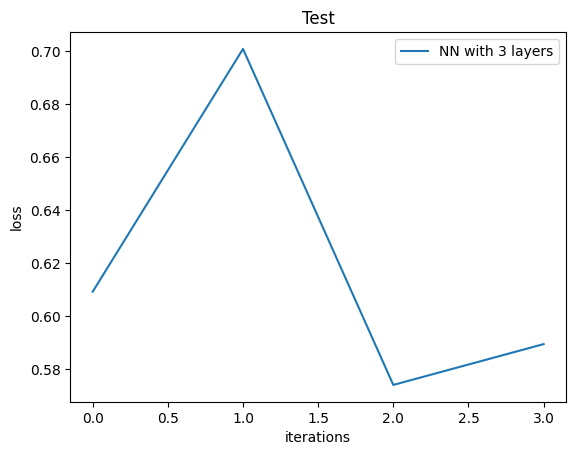

In [44]:
x1 = np.arange(len(chunks_val))

plt.plot(x1, chunks_val, label = "NN with 3 layers")


plt.title('Test')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

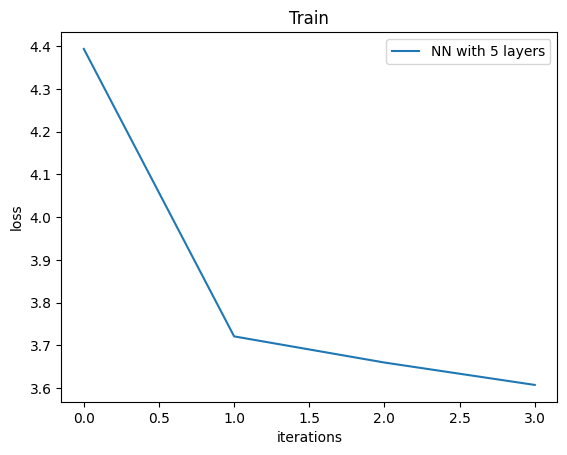

In [45]:
x1 = np.arange(len(chunks))

plt.plot(x1, chunks, label = "NN with 5 layers")


plt.title('Train')
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

И это изменение тоже не дало прироста. Наверняка не имеет смысла менять выходы после MF, т.к. они уже и так имет большую корреляцию между пользователем и объектом.